In [1]:
import sys
import time
sys.path.append('../lib')
from func_MSR import *
import pandas as pd

In [2]:
import numpy as np
from numpy.random import Generator, PCG64 ,MT19937, PCG64DXSM
from scipy.stats import truncnorm
import multiprocessing as mp

In [3]:
import matplotlib.pyplot as plt

In [4]:
path="../data_extract/"
ratid=21012
chunksize=20 #in minutes
rats=[20382,24101,21012,22295,20630,22098,23783,24116]
df=pd.read_json(path+"Rat_"+str(ratid)+"_data_extracted.json");
df.columns

Index(['RAT_ID', 'NeuID', 'N_DID', 'N_GID', 'LOC', 'STAT', 'rSCC', 'bScore',
       'hdScore', 'u_spiketime', 'task', 'U_GID', 'time_range', 'duration',
       'REC_Date', 'X', 'Y', 't', 'HD', 'MDirection', 'Speed', 'pmap'],
      dtype='object')

D.animals(3).sessions(18) contains- id: 104

D.animals(3).sessions(18).userData.containedNeurons.ids contains: 36 neuron recordings (units)\
D.animals(3).recordings(18).sessions.userData.containedNeurons.ids

D.animals(3).sessions(18).userData.containedNeurons.locs contains: 20 SUBs and 16 CA1s\
D.animals(3).recordings(18).sessions.userData.containedNeurons.locs

In [5]:
neuron_Dids=[99,105,124,130,132,137,143,148,154,161,165,169,171,176,179,182,186,202,204,207,209,211,213,214,215,219,225,231,239,243,247,251,253,256,259,262]

unit_Gids=[4893,4942,5070,5122,5164,5262,5317,5374,5430,5486,5525,5562,5574,5650,5691,5735,5780,5941,5954,5967,5980,5990,6002,6010,6018,6041,6082,6122,6193,6240,6275,6295,6305,6327,6339,6353]


In [6]:
# Function to find the indices
def find_indices(df, column, items):
    results = []
    for item in items:
        for row_idx, row in df.iterrows():
            if item in row[column]:
                results.append((row_idx, row[column].index(item),item))
    return results

In [7]:
#df[df['N_DID'].isin(neuron_Dids)]['U_GID']
NuUnis = find_indices(df[df['N_DID'].isin(neuron_Dids)], 'U_GID', unit_Gids)
#len(NuUnis)

In [8]:
def truncated_normal_toss(mu, jitter, M, no_of_samples, seed=1244):
    # Initialize the random number generator
    #rng = Generator(PCG64DXSM(seed=seed))
    rng = Generator(PCG64DXSM())
    # Calculate the lower and upper bounds for the truncation
    sigma=jitter/(2*np.pi)
    lower, upper = (-jitter - mu) / sigma, (jitter - mu) / sigma
    truncated_normal = truncnorm(lower, upper, loc=mu, scale=sigma)
    # Generate the samples
    samples = truncated_normal.rvs(size=(M, no_of_samples), random_state=rng)
    return samples
def worker_function(idx):
    jtdat=df.iloc[nu].u_spiketime[uni] + samples[:,idx]
    return MSR(jtdat,df.iloc[nu].time_range[uni][0],df.iloc[nu].time_range[uni][0]+(chunksize*60),200)

In [9]:
#5 10 50 100 500 1000 milisecs
jitter=5/1000 #5ms
no_of_samples = 5000

In [10]:
# datas=[]
# for (nu,uni,ugids) in NuUnis:
#     assert df.iloc[nu].U_GID[uni]==ugids, "UIDs don't match"
#     loc=df.iloc[nu].LOC[1]
#     print(f"Calculating for %s neuron: %d, unit: %d, U_GID: %d" % (loc,nu,uni,ugids))
#     nj_results=np.array(MSR(df.iloc[nu].u_spiketime[uni],df.iloc[nu].time_range[uni][0],df.iloc[nu].time_range[uni][0]+(chunksize*60),200))
#     # Output 9 dims
#     #no-of-spikes->len(datas),msr,OHKs,OHSs,maxHkpHs,Tohks,MHKs,MHSs,Tmhks
#     #samples from the truncated normal distribution for the jittering
#     samples = truncated_normal_toss(0, jitter, int(nj_results[0]), no_of_samples)
#     #Create pool of workers for jittering MSR calculation
#     pool = mp.Pool(14) 
#     future_res = [pool.apply_async(worker_function, (param,)) for param in range(no_of_samples)]
#     res = [f.get() for f in future_res]
#     # Close the pool and wait for the work to finish
#     pool.close()
#     pool.join()

#     nspikes,msr,OHKs,OHSs,maxHkpHs,Tohk,MHKs,MHSs,Tmhks=nj_results

#     #Calculating the displacement of the jittered MSR and other ResRel Quantities against unjittered MSR and other ResRel Quantities
#     displacement=np.abs(res - nj_results) 
#     _,mu_msrDSP,mu_OHKsDSP,mu_OHSsDSP,mu_maxHkpHsDSP,mu_TohkDSP,mu_MHKsDSP,mu_MHSsDSP,mu_TmhksDSP=np.mean(displacement,axis=0)

#     row = {
#         "ratid": ratid,
#         "nu_index": nu,
#         "unit_index": uni,
#         "U_GID": ugids,
#         "LOC": loc,
#         "nspikes": nspikes,
#         "msr": msr,
#         "OHKs": OHKs,
#         "OHSs": OHSs,
#         "maxHkpHs": maxHkpHs,
#         "Tohk": Tohk,
#         "MHKs": MHKs,
#         "MHSs": MHSs,
#         "Tmhks": Tmhks,
#         "mean_msrDSP": mu_msrDSP,
#         "mean_OHKsDSP": mu_OHKsDSP,
#         "mean_OHSsDSP": mu_OHSsDSP,
#         "mean_maxHkpHsDSP": mu_maxHkpHsDSP,
#         "mean_TohkDSP": mu_TohkDSP,
#         "mean_MHKsDSP": mu_MHKsDSP,
#         "mean_MHSsDSP": mu_MHSsDSP,
#         "mean_TmhksDSP": mu_TmhksDSP
#     }
#     datas.append(row)

# jitter_data=pd.DataFrame(datas)
# jitter_data.to_json("Rat_"+str(ratid)+"_Rec_"+str(18)+"_jitter_"+str(int(jitter*1000))+"ms_data.json",orient="records")
   

Calculating for neuron: 6, unit: 3, U_GID: 4893
Calculating for neuron: 12, unit: 0, U_GID: 4942
Calculating for neuron: 31, unit: 2, U_GID: 5070
Calculating for neuron: 37, unit: 2, U_GID: 5122
Calculating for neuron: 39, unit: 2, U_GID: 5164
Calculating for neuron: 44, unit: 2, U_GID: 5262
Calculating for neuron: 50, unit: 2, U_GID: 5317
Calculating for neuron: 55, unit: 2, U_GID: 5374
Calculating for neuron: 61, unit: 2, U_GID: 5430
Calculating for neuron: 68, unit: 2, U_GID: 5486
Calculating for neuron: 72, unit: 2, U_GID: 5525
Calculating for neuron: 76, unit: 0, U_GID: 5562
Calculating for neuron: 78, unit: 2, U_GID: 5574
Calculating for neuron: 83, unit: 2, U_GID: 5650
Calculating for neuron: 86, unit: 2, U_GID: 5691
Calculating for neuron: 89, unit: 2, U_GID: 5735
Calculating for neuron: 93, unit: 2, U_GID: 5780
Calculating for neuron: 109, unit: 2, U_GID: 5941
Calculating for neuron: 111, unit: 2, U_GID: 5954
Calculating for neuron: 114, unit: 1, U_GID: 5967
Calculating for ne

## Single Recording

In [15]:
## Checking the duration of the recordings
nu,uni,ugids=NuUnis[2];
print(df.iloc[nu].U_GID[uni],df.iloc[nu].duration[uni],df.iloc[nu].LOC[1],ugids)

5070 1058.725693503256 SUB 5070


In [16]:
## 20 min chunk test
print(MSR(df.iloc[nu].u_spiketime[uni],df.iloc[nu].time_range[uni][0],df.iloc[nu].time_range[uni][-1],200))
#for The spike train of length = chunksize
print(MSR(df.iloc[nu].u_spiketime[uni],df.iloc[nu].time_range[uni][0],df.iloc[nu].time_range[uni][0]+(chunksize*60),200))

(3045, np.float64(0.275639691638745), np.float64(0.2345425242478744), np.float64(0.8758157725390185), np.float64(1.110358296786893), np.float64(0.5524100857602311), np.float64(0.4540778641159537), np.float64(0.5352867424147735), np.float64(13.52137460595856))
(3045, np.float64(0.2756547029473171), np.float64(0.24824343868488202), np.float64(0.8628079098876413), np.float64(1.1110513485725233), np.float64(0.6488886731980871), np.float64(0.4520627130667849), np.float64(0.5328343111828758), np.float64(13.784576676401947))


In [17]:
def truncated_normal_toss(mu, jitter, M, no_of_samples, seed=1244):
    # Initialize the random number generator
    #rng = Generator(PCG64DXSM(seed=seed))
    rng = Generator(PCG64DXSM())
    # Calculate the lower and upper bounds for the truncation
    sigma=jitter/(2*np.pi)
    lower, upper = (-jitter - mu) / sigma, (jitter - mu) / sigma
    truncated_normal = truncnorm(lower, upper, loc=mu, scale=sigma)
    # Generate the samples
    samples = truncated_normal.rvs(size=(M, no_of_samples), random_state=rng)
    return samples

In [18]:
jitter=5/1000 #5ms
M=len(df.iloc[nu].u_spiketime[uni])
no_of_samples = 5000
mu=0
samples = truncated_normal_toss(mu, jitter, M, no_of_samples)
#plt.hist(samples[:,np.random.randint(0,no_of_samples)],bins=50)

In [19]:
def worker_function(idx):
    jtdat=df.iloc[nu].u_spiketime[uni] + samples[:,idx]
    return MSR(jtdat,df.iloc[nu].time_range[uni][0],df.iloc[nu].time_range[uni][0]+(chunksize*60),200)

In [20]:
nj_results=np.array(MSR(df.iloc[nu].u_spiketime[uni],df.iloc[nu].time_range[uni][0],df.iloc[nu].time_range[uni][0]+(chunksize*60),200))
# Output 9 dims
#no-of-spikes->len(datas),msr,OHKs,OHSs,maxHkpHs,Tohks,MHKs,MHSs,Tmhks

(array([  1.,   1.,   0.,   1.,   2.,   4.,   2.,   7.,   5.,   5.,  11.,
         14.,  10.,  20.,  22.,  28.,  37.,  36.,  48.,  39.,  63.,  60.,
         66.,  95.,  83.,  97., 101., 126.,  97., 141., 129., 158., 171.,
        161., 173., 167., 192., 195., 186., 201., 172., 188., 181., 158.,
        155., 143., 144., 118., 120., 103.,  92., 100.,  74.,  58.,  60.,
         38.,  31.,  27.,  22.,   9.,  17.,  12.,   7.,   4.,   5.,   2.,
          2.,   2.,   0.,   1.]),
 array([0.27543778, 0.27544279, 0.27544781, 0.27545282, 0.27545783,
        0.27546284, 0.27546785, 0.27547286, 0.27547787, 0.27548288,
        0.27548789, 0.2754929 , 0.27549791, 0.27550292, 0.27550793,
        0.27551294, 0.27551795, 0.27552297, 0.27552798, 0.27553299,
        0.275538  , 0.27554301, 0.27554802, 0.27555303, 0.27555804,
        0.27556305, 0.27556806, 0.27557307, 0.27557808, 0.27558309,
        0.2755881 , 0.27559312, 0.27559813, 0.27560314, 0.27560815,
        0.27561316, 0.27561817, 0.27562318, 0.

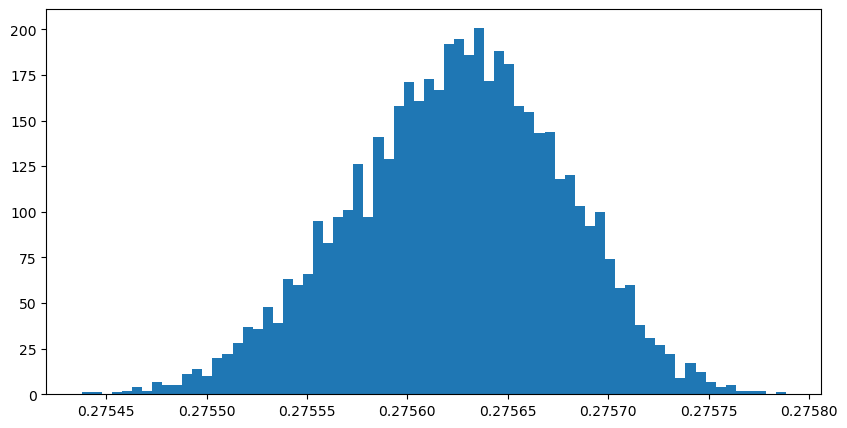

In [21]:
params = range(no_of_samples)  # Example iterable
    
with mp.Pool(10) as pool:
    async_results = []
    
    for param in params:
        async_result = pool.apply_async(worker_function, (param,))
        async_results.append(async_result)
    
    # Retrieve results
    results = np.array([ar.get() for ar in async_results])

plt.figure(figsize=(10,5))
plt.hist(np.array(results)[:,1],bins=70)

(array([  1.,   1.,   0.,   1.,   2.,   4.,   2.,   7.,   5.,   5.,  11.,
         14.,  10.,  20.,  22.,  28.,  37.,  36.,  48.,  39.,  63.,  60.,
         66.,  95.,  83.,  97., 101., 126.,  97., 141., 129., 158., 171.,
        161., 173., 167., 192., 195., 186., 201., 172., 188., 181., 158.,
        155., 143., 144., 118., 120., 103.,  92., 100.,  74.,  58.,  60.,
         38.,  31.,  27.,  22.,   9.,  17.,  12.,   7.,   4.,   5.,   2.,
          2.,   2.,   0.,   1.]),
 array([0.27543778, 0.27544279, 0.27544781, 0.27545282, 0.27545783,
        0.27546284, 0.27546785, 0.27547286, 0.27547787, 0.27548288,
        0.27548789, 0.2754929 , 0.27549791, 0.27550292, 0.27550793,
        0.27551294, 0.27551795, 0.27552297, 0.27552798, 0.27553299,
        0.275538  , 0.27554301, 0.27554802, 0.27555303, 0.27555804,
        0.27556305, 0.27556806, 0.27557307, 0.27557808, 0.27558309,
        0.2755881 , 0.27559312, 0.27559813, 0.27560314, 0.27560815,
        0.27561316, 0.27561817, 0.27562318, 0.

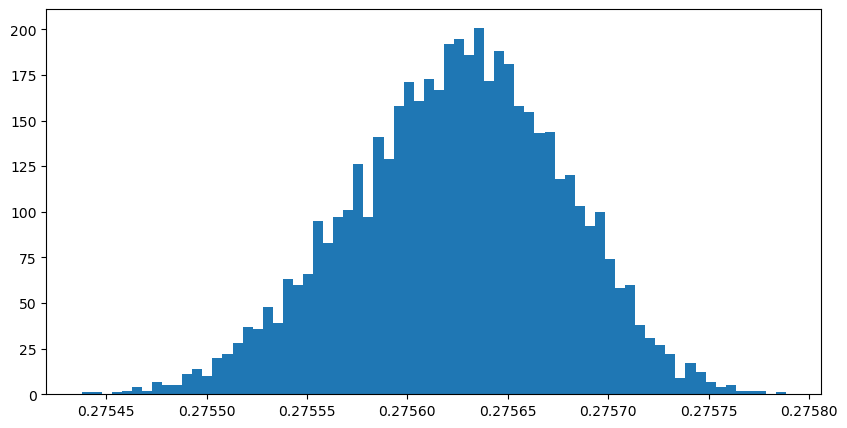

In [22]:
pool = mp.Pool(10) 
future_res = [pool.apply_async(worker_function, (param,)) for param in range(no_of_samples)]
res = [f.get() for f in future_res]
# Close the pool and wait for the work to finish
pool.close()
pool.join()

plt.figure(figsize=(10,5))
plt.hist(np.array(results)[:,1],bins=70)

In [23]:
nspikes,msr,OHKs,OHSs,maxHkpHs,Tohk,MHKs,MHSs,Tmhks=nj_results
displacement=np.abs(res - nj_results)
_,mu_msrDSP,mu_OHKsDSP,mu_OHSsDSP,mu_maxHkpHsDSP,mu_TohkDSP,mu_MHKsDSP,mu_MHSsDSP,mu_TmhksDSP=np.mean(displacement,axis=0)
#_,sg_msr,sg_OHKs,sg_OHSs,sg_maxHkpHs,sg_Tohk,sg_MHKs,sg_MHSs,sg_Tmhks=np.std(displacement,axis=0)

In [27]:
np.shape(res)

(5000, 9)

In [24]:

row = {
    "ratid": ratid,
    "nu_index": nu,
    "unit_index": uni,
    "U_GID": ugids,
    "loc": df.iloc[nu].LOC[1],
    "nspikes": nspikes,
    "msr": msr,
    "OHKs": OHKs,
    "OHSs": OHSs,
    "maxHkpHs": maxHkpHs,
    "Tohk": Tohk,
    "MHKs": MHKs,
    "MHSs": MHSs,
    "Tmhks": Tmhks,
    "mean_msrDSP": mu_msrDSP,
    "mean_OHKsDSP": mu_OHKsDSP,
    "mean_OHSsDSP": mu_OHSsDSP,
    "mean_maxHkpHsDSP": mu_maxHkpHsDSP,
    "mean_TohkDSP": mu_TohkDSP,
    "mean_MHKsDSP": mu_MHKsDSP,
    "mean_MHSsDSP": mu_MHSsDSP,
    "mean_TmhksDSP": mu_TmhksDSP
}
row

{'ratid': 21012,
 'nu_index': 31,
 'unit_index': 2,
 'U_GID': 5070,
 'loc': 'SUB',
 'nspikes': np.float64(3045.0),
 'msr': np.float64(0.2756547029473171),
 'OHKs': np.float64(0.24824343868488202),
 'OHSs': np.float64(0.8628079098876413),
 'maxHkpHs': np.float64(1.1110513485725233),
 'Tohk': np.float64(0.6488886731980871),
 'MHKs': np.float64(0.4520627130667849),
 'MHSs': np.float64(0.5328343111828758),
 'Tmhks': np.float64(13.784576676401947),
 'mean_msrDSP': np.float64(4.8342861693358986e-05),
 'mean_OHKsDSP': np.float64(0.00013374337421869487),
 'mean_OHSsDSP': np.float64(8.650274431969168e-05),
 'mean_maxHkpHsDSP': np.float64(8.322333711811662e-05),
 'mean_TohkDSP': np.float64(0.0),
 'mean_MHKsDSP': np.float64(0.0010505418617092236),
 'mean_MHSsDSP': np.float64(0.0019978692140363878),
 'mean_TmhksDSP': np.float64(0.21253970196594746)}

In [26]:
print(f"Calculating for %s neuron: %d, unit: %d, U_GID: %d" % (df.iloc[nu].LOC[1],nu,uni,ugids))

Calculating for SUB neuron: 31, unit: 2, U_GID: 5070
